# Case study 2: Increasing mortality risk with age in *Telostylinus angusticollis*

In [1]:
%load_ext autoreload 
%autoreload 2

import sys

import numpy as np

sys.path.insert(0, '../') # The following modules are in the directory above
import figures
from cohort_model import (
    get_mean_and_std,
    population_survivorship_difference,
    run_cohort_simulation, 
    HYP_WILDTYPE,
    MUT_CAPTIVITY,
    MUT_WILD
)

In [2]:
#############################
### Parameter definitions ###
#############################

individual_count = 1000

# Max age for males (_m) and females (_f), rescaled to max age in wild (females) = 100
t_m_cap_f = 325
t_m_cap_m = 290
t_m_wild_f = 100
t_m_wild_m = 53

epsilon = 0.04
epsilons = np.array([0., 0.01, 0.02, 0.03, 0.04])

# The parameters below are based on previous least-squares curve fitting 
# (see Telostylinus parameter estimation notebook for method)
alpha_f = 0.00287
kappa_f = 0.00842

alpha_m = 0.00057
kappa_m = 0.0173

hazard_rate_f = 0.0524 # For epsilon = 0.04
hazard_rate_m = 0.0453 # For epsilon = 0.04
hazard_rates_wt_f = np.array([0.0503, 0.0508, 0.0513, 0.05185, 0.05239])     # For epsilons = [0, 0.01, 0.02, 0.03, 0.04]
hazard_rates_wt_m = np.array([0.0435, 0.04393, 0.044387, 0.044845, 0.04531]) # For epsilons = [0, 0.01, 0.02, 0.03, 0.04]

omega = 0.0001
tau = 1.8

## Survivorship curves (Figure 4 in paper)

In [3]:
# Figure 4 parameters (which are not already defined in first parameter definition cell)
repetition_count = 100

In [4]:
# FEMALE CAPTIVITY
hazard_rate_params = dict(alpha=alpha_f, kappa=kappa_f, population=MUT_CAPTIVITY)
captivity_f = run_cohort_simulation(repetition_count, individual_count, hazard_rate_params, t_m_cap_f)

In [5]:
# MALE CAPTIVITY
hazard_rate_params = dict(alpha=alpha_m, kappa=kappa_m, population=MUT_CAPTIVITY)
captivity_m = run_cohort_simulation(repetition_count, individual_count, hazard_rate_params, t_m_cap_m)

In [6]:
# FEMALE WILD
hazard_rate_params = dict(alpha=alpha_f, kappa=kappa_f, epsilon=epsilon, hazard_rate_wt=hazard_rate_f, population=MUT_WILD)
wild_f = run_cohort_simulation(repetition_count, individual_count, hazard_rate_params, t_m_wild_f)

In [7]:
# MALE WILD
hazard_rate_params = dict(alpha=alpha_m, kappa=kappa_m, epsilon=epsilon, hazard_rate_wt=hazard_rate_m, omega=omega, tau=tau, population=MUT_WILD)
wild_m = run_cohort_simulation(repetition_count, individual_count, hazard_rate_params, t_m_wild_m)

In [8]:
# NORMALIZED MEAN
cap_f_mean, _ = get_mean_and_std(captivity_f)
cap_m_mean, _ = get_mean_and_std(captivity_m)
wild_f_mean, _ = get_mean_and_std(wild_f)
wild_m_mean, _ = get_mean_and_std(wild_m)

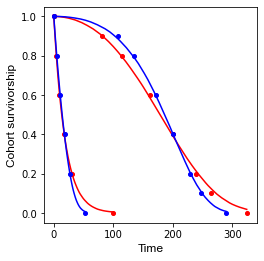

In [9]:
figures.plot_fig_4(t_m_cap_f, t_m_cap_m, t_m_wild_f, t_m_wild_m, cap_f_mean, cap_m_mean, wild_f_mean, wild_m_mean)

## Difference between area under survivorship curves for mutant and hypothetical wild type (results reported in paper)

In [10]:
# Area under curve parameters, common to both female and male calculations
# (which are not already defined in first parameter definition cell)
repetition_count = 1000

### Females

In [11]:
# Female parameters
hazard_rate_params = dict(alpha=alpha_f, kappa=kappa_f) # No omega & tau for females

In [12]:
%%time
population_simulations_f, mean_diff_f, std_diff_f = population_survivorship_difference(
    individual_count=individual_count,
    repetition_count=repetition_count,
    epsilons=epsilons,
    hazard_rates_wt=hazard_rates_wt_f,
    t_m=t_m_wild_f,
    populations=(MUT_WILD, HYP_WILDTYPE),
    hazard_rate_params=hazard_rate_params
)
mutant_f = np.array(population_simulations_f[MUT_WILD])
hyp_wt_f = np.array(population_simulations_f[HYP_WILDTYPE])

CPU times: user 2min 25s, sys: 1min 52s, total: 4min 17s
Wall time: 4min 24s


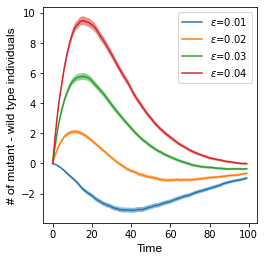

In [13]:
# Inspect predicted temporal difference for females (not shown in paper)
# Using figure 2 plotting function for convenience
figures.plot_fig_2(t_m_wild_f, mean_diff_f, std_diff_f, repetition_count, save_pdf=False) 

In [14]:
# Calculate the percentage of cases where the mutant has a larger area than the hypothetical wild type
area_mut_f = np.trapz(mutant_f)
area_hyp_wt_f = np.trapz(hyp_wt_f)
area_diff_f = np.subtract(area_mut_f, area_hyp_wt_f)
percentage_diff_f = np.sum(area_diff_f > 0, axis=1) / repetition_count * 100

In [15]:
print(f"Female, wild mutant wins {[float(x) for x in percentage_diff_f]} percent of the time at epsilon values of {[float(num) for num in epsilons]}, respectively.\n")

Female, wild mutant wins [0.0, 40.0, 99.6, 100.0, 100.0] percent of the time at epsilon values of [0.0, 0.01, 0.02, 0.03, 0.04], respectively.



### Males

In [16]:
# Male parameters
hazard_rate_params = dict(alpha=alpha_m, kappa=kappa_m, omega=omega, tau=tau)

In [17]:
%%time
population_simulations_m, mean_diff_m, std_diff_m = population_survivorship_difference(
    individual_count=individual_count,
    repetition_count=repetition_count,
    epsilons=epsilons,
    hazard_rates_wt=hazard_rates_wt_m,
    t_m=t_m_wild_m,
    populations=(MUT_WILD, HYP_WILDTYPE),
    hazard_rate_params=hazard_rate_params    
)
mutant_m = np.array(population_simulations_m[MUT_WILD])
hyp_wt_m = np.array(population_simulations_m[HYP_WILDTYPE])

CPU times: user 52.2 s, sys: 28.5 s, total: 1min 20s
Wall time: 1min 24s


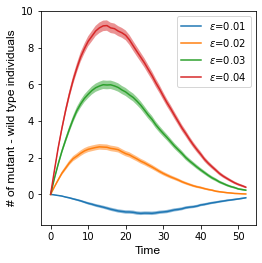

In [18]:
# Inspect predicted temporal difference for males (not shown in paper)
# Using figure 2 plotting function for convenience
figures.plot_fig_2(t_m_wild_m, mean_diff_m, std_diff_m, repetition_count, save_pdf=False) 

In [19]:
# Calculate the percentage of cases where the mutant has a larger area than the hypothetical wild type
area_mut_m = np.trapz(mutant_m)
area_hyp_wt_m = np.trapz(hyp_wt_m)
area_diff_m = np.subtract(area_mut_m, area_hyp_wt_m)
percentage_diff_m = np.sum(area_diff_m > 0, axis=1) / repetition_count * 100

In [20]:
print(f"Male, wild mutant wins {[float(x) for x in percentage_diff_m]} percent of the time at epsilon values of {[float(num) for num in epsilons]}, respectively.")

Male, wild mutant wins [0.0, 98.6, 100.0, 100.0, 100.0] percent of the time at epsilon values of [0.0, 0.01, 0.02, 0.03, 0.04], respectively.
